In [1]:
# Import Data
import pandas as pd

dataframe = pd.read_csv("Online Retail.csv", encoding = "ISO-8859-1")
dataframe["InvoiceDate"] = pd.to_datetime(dataframe["InvoiceDate"])
dataframe.head()


# Calculate RFM
dataframe['TotalSum'] = dataframe['Quantity'] * dataframe['UnitPrice']
snapshot_date = max(dataframe.InvoiceDate)
datamart = dataframe.groupby('CustomerID').agg(
    {
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'TotalSum': 'sum'
    }
).round(1)

datamart.rename(

    columns={'InvoiceDate':'Recency', 'InvoiceNo': 'Frequency', 'TotalSum':'Monetary'}, 
    inplace=True
)

# Normalize Data
from pre_processing import pre_processing
datamart_normalized = pre_processing(datamart)
print(datamart_normalized)

[[ 1.15675823 -2.23027241 -6.28046783]
 [-1.84932793  1.13341891  1.10386252]
 [ 0.3876675  -0.1864624   0.6060052 ]
 ...
 [-0.8379603  -0.83449302 -0.7145243 ]
 [-1.27833502  2.19530371  0.69324521]
 [ 0.09328903  0.42090602  0.61856518]]


[]

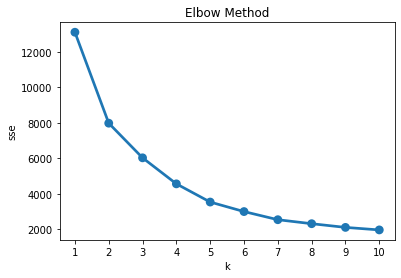

In [5]:
# Methods to define the number of clusters
    # Visualize Methods - elbow critrion -> with in cluster SSE
    # Mathematical Methods - silhouette coefficient
    # Experimentation and Interpetation

#Choosing the number of clusters

from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

sse = {}
for k in range(1, 11):

    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_

plt.title('The Elbow Method')
plt.xlabel('k') 
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.plot()

In [9]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_
print(cluster_labels)
print(kmeans.cluster_centers_)

# Analyze Clusters

datamart_RFM_K3 = datamart.assign(Cluster = cluster_labels)

datamart_RFM_K3.groupby('Cluster').agg(
    {
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': ['mean', 'count']
    }
).round(1)

[1 0 2 ... 2 0 0]
[[-0.68710587  0.8621429   0.66228858]
 [ 0.74427483 -1.77360309 -6.28046783]
 [ 0.47974731 -0.58353828 -0.34037359]]


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          26.3     187.6   3905.5  1815
1         222.6      10.8   -240.5    55
2         135.1      26.3    489.6  2502

<AxesSubplot:title={'center':'Snake Plot'}, xlabel='Attribute', ylabel='Value'>

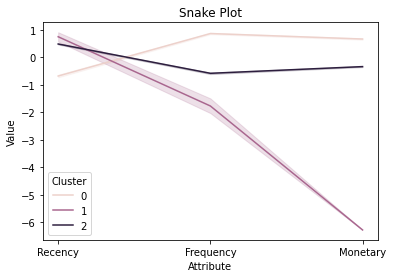

In [12]:
# Profile and interpret segments

# Snake Plot

datamart_DF = pd.DataFrame(
    data=datamart_normalized,
    index=datamart.index,
    columns=datamart.columns,
)

datamart_DF['Cluster'] = datamart_RFM_K3['Cluster']

datamart_melt = pd.melt(
    datamart_DF.reset_index(),
    id_vars=['CustomerID', 'Cluster'],
    value_vars=['Recency', 'Frequency', 'Monetary'],
    var_name='Attribute',
    value_name='Value'
)

datamart_melt.head(10)

plt.title('Snake Plot')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=datamart_melt)

            Recency   Frequency     Monetary
Cluster                                     
0         26.324518  187.626997  3905.451680
1        222.636364   10.781818  -240.530909
2        135.105516   26.256195   489.568385
Recency        91.047118
Frequency      93.053294
Monetary     1898.459675
dtype: float64
         Recency  Frequency  Monetary
Cluster                              
0          -0.71       1.02      1.06
1           1.45      -0.88     -1.13
2           0.48      -0.72     -0.74


<AxesSubplot:ylabel='Cluster'>

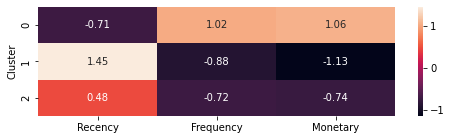

In [24]:
# Profile and interpret segments
    # Relative Importance of segment attribute

cluster_avg = datamart_RFM_K3.groupby('Cluster').mean()
print(cluster_avg)
population_avg = datamart.mean()
print(population_avg)
relative_map = cluster_avg / population_avg -1
relative_map = relative_map.round(2)
print(relative_map)
plt.figure(figsize=(8, 2))
sns.heatmap(relative_map, annot=True, fmt='.2f', )